Features used: ['Strength_7', 'Rainfall_Code', 'AvgTemp_0to28', 'GDD_28', 'TotalRainfall_28', 'AvgHumidity_28']

   28-DAY STRENGTH MODEL (CatBoost)
   > R² Score:   -0.1822
   > MAE:        1.8116 MPa
   > MSE:        5.8351
   > RMSE:       2.4156 MPa
   > MAPE:       4.94%
------------------------------


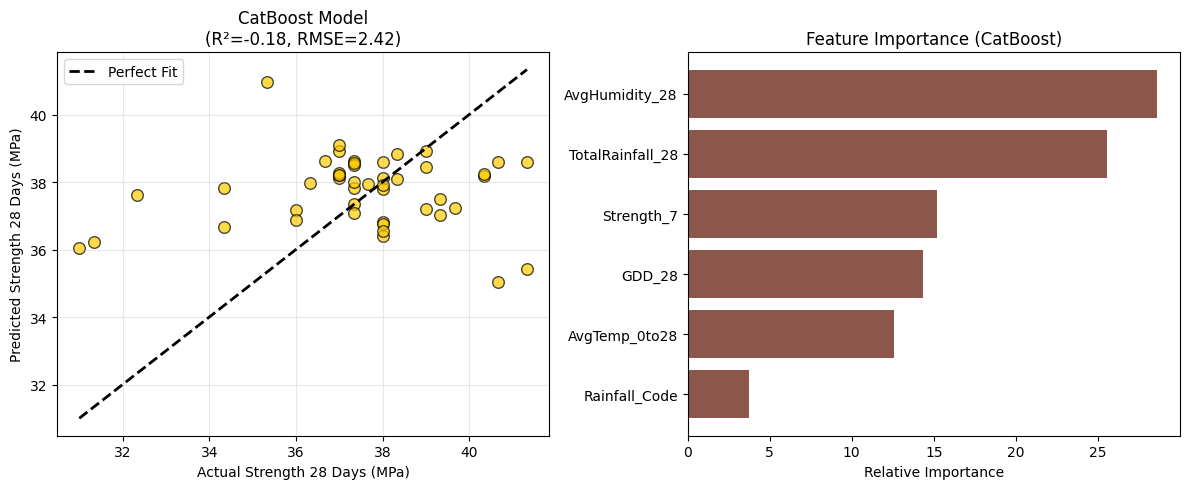

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# --- 1. LOAD DATA ---
df_local = pd.read_csv("Data/localdataset.csv")
df_local.columns = df_local.columns.str.strip()

# --- 2. DEFINE FEATURES FOR 28-DAY MODEL ---
features_28d = [
    # Ingredients
    'Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 
    'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age',
    
    # Measured Early Strength (Crucial Predictor)
    'Strength_7',
    
    # Environmental Factors (Casting Day)
    'Rainfall_Code', 
    
    # Environmental Factors (Curing Period 0-28 Days)
    'AvgTemp_0to28', 
    'GDD_28', 
    'TotalRainfall_28', 
    'AvgHumidity_28'
]

# Select only available columns
available_cols = [c for c in features_28d if c in df_local.columns]
print(f"Features used: {available_cols}")

X = df_local[available_cols]
y = df_local['Strength_28']

# --- 3. TRAIN MODEL (CatBoost) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize CatBoost
# verbose=0 silences the training output
cb_model = CatBoostRegressor(n_estimators=200, learning_rate=0.1, depth=3, random_state=42, verbose=0)

# Fit the model
cb_model.fit(X_train, y_train)

# --- 4. PREDICT & EVALUATE ---
predictions = cb_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Print Report
print("\n" + "="*40)
print("   28-DAY STRENGTH MODEL (CatBoost)")
print("="*40)
print(f"   > R² Score:   {r2:.4f}")
print(f"   > MAE:        {mae:.4f} MPa")
print(f"   > MSE:        {mse:.4f}")
print(f"   > RMSE:       {rmse:.4f} MPa")
print(f"   > MAPE:       {mape:.2%}")
print("-" * 30)

# --- 5. VISUALIZATION ---
plt.figure(figsize=(12, 5))

# Plot 1: Actual vs Predicted
plt.subplot(1, 2, 1)
# Using Golden/Yellowish color for CatBoost
plt.scatter(y_test, predictions, color='#ffcc00', alpha=0.7, edgecolors='k', s=70)
min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Fit')
plt.xlabel("Actual Strength 28 Days (MPa)")
plt.ylabel("Predicted Strength 28 Days (MPa)")
plt.title(f"CatBoost Model\n(R²={r2:.2f}, RMSE={rmse:.2f})")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Feature Importance
plt.subplot(1, 2, 2)
importances = cb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importance (CatBoost)')
plt.barh(range(len(indices)), importances[indices], color='#8c564b', align='center')
plt.yticks(range(len(indices)), [available_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()

plt.show()